### Step 1 : Importing Libraries

In [1]:
import tensorflow as tf
import yfinance as yf
import pandas as pd
import numpy as np
import keras
import matplotlib.pyplot as ptl

In [2]:
tf.__version__

'2.15.0'

### Steep 2 : Downloading data through yfinance, i.e. Yahoo Finance
###### To analyze GOOGLE stocks patterns, we need historical stock price data. Here's where yfinance comes into play. This library is designed to fetch historical data from Yahoo Finance.

In [3]:
# Fetch GOOG data
amzn_data = yf.download('AMZN', start='2020-01-01', end='2024-07-01')

# Display the first few rows of the dataframe
amzn_data.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,93.750000,94.900497,93.207497,94.900497,94.900497,80580000
2020-01-03,93.224998,94.309998,93.224998,93.748497,93.748497,75288000
2020-01-06,93.000000,95.184502,93.000000,95.143997,95.143997,81236000
2020-01-07,95.224998,95.694504,94.601997,95.343002,95.343002,80898000
2020-01-08,94.902000,95.550003,94.321999,94.598503,94.598503,70160000


##### This script fetches the daily stock prices of Alphabet Inc.(Google) from January 1, 2020, to June 28, 2024.

In [4]:
amzn_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,93.750000,94.900497,93.207497,94.900497,94.900497,80580000
2020-01-03,93.224998,94.309998,93.224998,93.748497,93.748497,75288000
2020-01-06,93.000000,95.184502,93.000000,95.143997,95.143997,81236000
2020-01-07,95.224998,95.694504,94.601997,95.343002,95.343002,80898000
2020-01-08,94.902000,95.550003,94.321999,94.598503,94.598503,70160000
...,...,...,...,...,...,...
2024-06-24,189.330002,191.000000,185.330002,185.570007,185.570007,50610400
2024-06-25,186.809998,188.839996,185.419998,186.339996,186.339996,45898500
2024-06-26,186.919998,194.800003,186.259995,193.610001,193.610001,65103900


### Step 3 : Data Preprocessing and Preparation

#### Data Cleaning
###### - Identifying Missing Values
###### - Handling Naomalies

In [5]:
# Checking for missing values
amzn_data.isnull().sum()

# Filling missing values, if any
amzn_data.fillna(method='ffill', inplace=True)

#### Feature Selection
##### In stock market data, various features can be influential. Typically, ‘Open’, ‘High’, ‘Low’, ‘Close’, and ‘Volume’ are used.

#### Normalization

In [6]:
from sklearn.preprocessing import MinMaxScaler

scaler=MinMaxScaler(feature_range=(0, 1))
amzn_data_scaled=scaler.fit_transform(amzn_data['Close'].values.reshape(-1, 1))

#### Creating Sequences
##### LSTM models require input to be in a sequence format. We transform the data into sequences for the model to learn from.

##### Defining Sequence Length: Choose a sequence length (like 60 days). This means, for every sample, the model will look at the last 60 days of data to make a prediction.

In [7]:
X=[]
y=[]

for i in range(60, len(amzn_data_scaled)):
    X.append(amzn_data_scaled[i-60:i, 0])
    y.append(amzn_data_scaled[i ,0])

#### Train-Test Split

In [8]:
# Here, we take 80% of data is used for training and 20% for testing.

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

#### Reshaping data for LSTM
##### Finally, we need to reshape our data into a 3D format [samples, time steps, features] required by LSTM layers. 3D dimension or new dimeension is (num_samples, time_steps, features) which was earlier (num_samples, time_steps)

In [9]:
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

### Step 4 : Building the LSTM with Attention model

#### The construction of our LSTM model with an added attention mechanism, tailored for predicting AMAZON stock patterns.

#### Creating LSTM Layers

##### Our LSTM model will consist of several layers, including LSTM layers for processing the time-series data. The basic structure is as follows:

In [10]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, AdditiveAttention, Permute, Reshape, Multiply

model = Sequential()

# Adding LSTM layers with return_sequences=True
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=True))

# units represent the number of neurons in each LSTM layer
# return_sequences=True is crucial in the first layers to ensure the output includes sequences, which are essential for stacking 
# LSTM layers. The final LSTM layer does not return sequences as we prepare the data for the attention layer.

##### Integrating the Attention Mechanism
###### The attention mechanism can be added to enhance the model’s ability to focus on relevant time steps:

In [11]:
# Adding self-attention mechanism
# The attention mechanism
attention=AdditiveAttention(name='attention_weight')

# Permute and shape for compatibility
model.add(Permute((2, 1)))
model.add(Reshape((-1, X_train.shape[1])))
attention_result=attention([model.output, model.output])
multiply_layer=Multiply()([model.output, attention_result])

# Return to original shape
model.add(Permute((2, 1)))
model.add(Reshape((-1, 50)))

# Adding a Flatten layer before the final dense layer
model.add(tf.keras.layers.Flatten())

# Final Dense Layer
model.add(Dense(1))

###### This custom layer computes a weighted sum of the input sequence, allowing the model to pay more attention to certain time steps.

##### Optimizing the model
###### To enhance the model’s performance and reduce the risk of overfitting, we include Dropout and Batch Normalization.

In [12]:
from keras.layers import BatchNormalization

# Adding Dropout and Batch Normalization
model.add(Dropout(0.2))
model.add(BatchNormalization())

###### Dropout helps in preventing overfitting by randomly setting a fraction of the input units to 0 at each update during training, and Batch Normalization stabilizes the learning process.

##### Model Compilation

In [13]:
# Compile the model with an optimizer and loss function suited for our regression task. 

model.compile(optimizer='adam', loss='mean_squared_error')

###### adam optimizer is generally a good choice for recurrent neural networks, and mean squared error works well as a loss function for regression tasks like ours.

##### Model Summary

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 60, 50)            20200     
                                                                 
 permute (Permute)           (None, 50, 60)            0         
                                                                 
 reshape (Reshape)           (None, 50, 60)            0         
                                                                 
 permute_1 (Permute)         (None, 60, 50)            0         
                                                                 
 reshape_1 (Reshape)         (None, 60, 50)            0         
                                                                 
 flatten (Flatten)           (None, 3000)              0

#### Training Code

In [15]:
# Assuming X_train and y_train are already defined and preprocessed
history = model.fit(X_train, y_train, epochs=100, batch_size=25, validation_split=0.2)

# The validation_split parameter reserves a portion of the training data for validation, 
# allowing us to monitor the model's performance on unseen data during training.

Epoch 1/100

28/28 [==============================] - 9s 88ms/step - loss: 0.3641 - val_loss: 0.3066
Epoch 2/100
28/28 [==============================] - 1s 38ms/step - loss: 0.2773 - val_loss: 0.2685
Epoch 3/100
28/28 [==============================] - 1s 44ms/step - loss: 0.2465 - val_loss: 0.2440
Epoch 4/100
28/28 [==============================] - 1s 38ms/step - loss: 0.2260 - val_loss: 0.2266
Epoch 5/100
28/28 [==============================] - 1s 39ms/step - loss: 0.2030 - val_loss: 0.2135
Epoch 6/100
28/28 [==============================] - 1s 36ms/step - loss: 0.1789 - val_loss: 0.1813
Epoch 7/100
28/28 [==============================] - 1s 38ms/step - loss: 0.1589 - val_loss: 0.1649
Epoch 8/100
28/28 [==============================] - 1s 35ms/step - loss: 0.1443 - val_loss: 0.1483
Epoch 9/100
28/28 [==============================] - 1s 36ms/step - loss: 0.1267 - val_loss: 0.1343
Epoch 10/100
28/28 [==============================] - 1s 42ms/step - loss: 0.1132 - val_loss: 0.128

#### Avoiding Overfitting

##### Overfitting occurs when a model learns patterns specific to the training data, which do not generalize to new data. Here are ways to avoid overfitting:

###### 1. Validation Set: Using a validation set (as we did in the training code) helps in monitoring the model’s performance on unseen data.
###### 2. Early Stopping: This technique stops training when the model’s performance on the validation set starts to degrade. Implementing early stopping in Keras is straightforward:

In [16]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(X_train, y_train, epochs=100, batch_size=25, validation_split=0.2, callbacks=[early_stopping])

# Here, patience=10 means training will stop if the validation loss does not improve for 10 consecutive epochs.
# Regularization Techniques: Techniques like Dropout and Batch Normalization, which are already included in our model,
# also help in reducing overfitting.

Epoch 1/100
28/28 [==============================] - 1s 48ms/step - loss: 0.0121 - val_loss: 0.0038
Epoch 2/100
28/28 [==============================] - 2s 63ms/step - loss: 0.0143 - val_loss: 0.0027
Epoch 3/100
28/28 [==============================] - 2s 60ms/step - loss: 0.0150 - val_loss: 0.0026
Epoch 4/100
28/28 [==============================] - 2s 65ms/step - loss: 0.0133 - val_loss: 0.0026
Epoch 5/100
28/28 [==============================] - 1s 46ms/step - loss: 0.0143 - val_loss: 0.0020
Epoch 6/100
28/28 [==============================] - 1s 51ms/step - loss: 0.0129 - val_loss: 0.0042
Epoch 7/100
28/28 [==============================] - 1s 53ms/step - loss: 0.0129 - val_loss: 0.0015
Epoch 8/100
28/28 [==============================] - 2s 56ms/step - loss: 0.0155 - val_loss: 0.0091
Epoch 9/100
28/28 [==============================] - 1s 50ms/step - loss: 0.0140 - val_loss: 0.0048
Epoch 10/100
28/28 [==============================] - 1s 47ms/step - loss: 0.0128 - val_loss: 0.0050

##### Optional : These are more callbacks

In [17]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, TensorBoard, CSVLogger

# Callback to savee the model periodically
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')

# Callback to reduce learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)

# Callback for Tensorboard
tensorboard = TensorBoard(log_dir='./logs')

# Callback to log details to a CSV file
csv_logger = CSVLogger('training_log.csv')

# Combining all callbacks
callbacks_list = [early_stopping, model_checkpoint, reduce_lr, tensorboard, csv_logger]

# Fit the model with the callbacks
history = model.fit(X_train, y_train, epochs=100, batch_size=25, validation_split=0.2, callbacks=callbacks_list)

Epoch 1/100
28/28 [==============================] - 3s 50ms/step - loss: 0.0151 - val_loss: 0.0058 - lr: 0.0010
Epoch 2/100
 1/28 [>.............................] - ETA: 1s - loss: 0.0121

c:\Users\smara\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


28/28 [==============================] - 1s 46ms/step - loss: 0.0132 - val_loss: 0.0042 - lr: 0.0010
Epoch 3/100
28/28 [==============================] - 1s 49ms/step - loss: 0.0140 - val_loss: 0.0140 - lr: 0.0010
Epoch 4/100
28/28 [==============================] - 1s 50ms/step - loss: 0.0157 - val_loss: 0.0136 - lr: 0.0010
Epoch 5/100
28/28 [==============================] - 1s 47ms/step - loss: 0.0160 - val_loss: 0.0053 - lr: 0.0010
Epoch 6/100
28/28 [==============================] - 2s 78ms/step - loss: 0.0156 - val_loss: 0.0034 - lr: 0.0010
Epoch 7/100
28/28 [==============================] - 1s 52ms/step - loss: 0.0126 - val_loss: 0.0119 - lr: 0.0010
Epoch 8/100
28/28 [==============================] - 1s 48ms/step - loss: 0.0147 - val_loss: 0.0048 - lr: 0.0010
Epoch 9/100
28/28 [==============================] - 2s 56ms/step - loss: 0.0151 - val_loss: 0.0050 - lr: 0.0010
Epoch 10/100
28/28 [==============================] - 1s 42ms/step - loss: 0.0110 - val_loss: 0.0024 - lr: 0

### Step 5 : Evaluating Model Performance 

#### Evaluating with the test set
##### To evaluate the model, we first need to prepare our test data (X_test) in the same way we did for the training data. Then, we can use the model's evaluate function:

In [18]:
# Convert X_test and y_test to numpy arrays if they are not already
X_test=np.array(X_test)
y_test=np.array(y_test)

# Ensure X_test is reshaped similarly to how X_train was reshaped
# This depends on how you preprocessed the training data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Now evaluatee the model on the test data
test_loss = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)

7/7 [==============================] - 0s 18ms/step - loss: 0.0037
Test Loss: 0.0036911661736667156


#### Performance Metrics
##### In addition to the loss, other metrics can provide more insights into the model’s performance. For regression tasks like ours, common metrics include:

##### 1. Mean Absolute Error (MAE): This measures the average magnitude of the errors in a set of predictions, without considering their direction.
##### 2. Root Mean Square Error (RMSE): This is the square root of the average of squared differences between prediction and actual observation.

In [19]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Making Predictions
y_pred = model.predict(X_test)

# Calculating MAE and RMSE
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print("Mean Absolute Error : ", mae)
print("Root Mean Square Error : ", rmse)

7/7 [==============================] - 2s 15ms/step
Mean Absolute Error :  0.05094794126489605
Root Mean Square Error :  0.060754970451089706


##### A MAE of 0.0433 means that, on average, the model’s predictions are about 0.0433 units away from the actual values.
##### An RMSE of 0.0644 means that the model’s predictions are, on average, 0.0644 units away from the actual values when larger errors are penalized more.

### Step 6 : Predicting the next 4 candles(days) of AMAZON stock prices


In [20]:
# Fetching the latest 90 days of AMZN stock data
data = yf.download('AMZN', period='3mo', interval='1d')

# Selecting the 'Close' price and converting to numpy array
closing_prices = data['Close'].values

# Scaling the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(closing_prices.reshape(-1,1))

# Since we need the last 60 days (2 months) to predict the next day, we reshape the data accordingly
X_latest = np.array([scaled_data[-60:].reshape(60)])

# Reshaping the data for the model (adding batch dimension)
X_latest = np.reshape(X_latest, (X_latest.shape[0], X_latest.shape[1], 1))

# Making predictions for the next 4 candles
predicted_stock_price = model.predict(X_latest)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

print("Predicted Stock Prices for the next 4 days: ", predicted_stock_price)

[*********************100%%**********************]  1 of 1 completed

1/1 [==============================] - 0s 37ms/step
Predicted Stock Prices for the next 4 days:  [[173.24702]]


#### Predicting the price for the next 4 days

In [21]:
# Fetch the latest 60 days of AMZN stock data
data = yf.download('AMZN', period='3mo', interval='1d')

# Select 'Close' price and scale it
closing_prices = data['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(closing_prices)

# Predict the next 4 days iteratively
predicted_prices = []
current_batch = scaled_data[-60:].reshape(1, 60, 1)  # Most recent 60 days

for i in range(4):  # Predicting 4 days
    # Get the prediction (next day)
    next_prediction = model.predict(current_batch)
    
    # Reshape the prediction to fit the batch dimension
    next_prediction_reshaped = next_prediction.reshape(1, 1, 1)
    
    # Append the prediction to the batch used for predicting
    current_batch = np.append(current_batch[:, 1:, :], next_prediction_reshaped, axis=1)
    
    # Inverse transform the prediction to the original price scale
    predicted_prices.append(scaler.inverse_transform(next_prediction)[0, 0])

print("Predicted Stock Prices for the next 4 days: ", predicted_prices)

[*********************100%%**********************]  1 of 1 completed

1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 29ms/step
Predicted Stock Prices for the next 4 days:  [173.24702, 174.44434, 176.1749, 177.69319]


#### Visualization of Predictions

In [22]:
import mplfinance as mpf
import matplotlib.dates as mpl_dates
import matplotlib.pyplot as plt

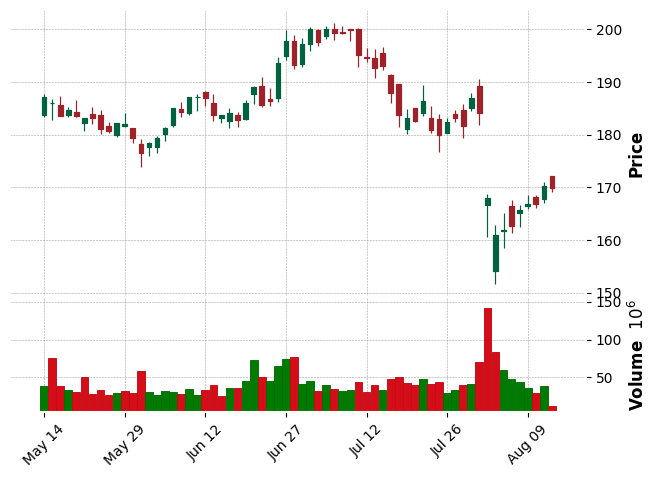

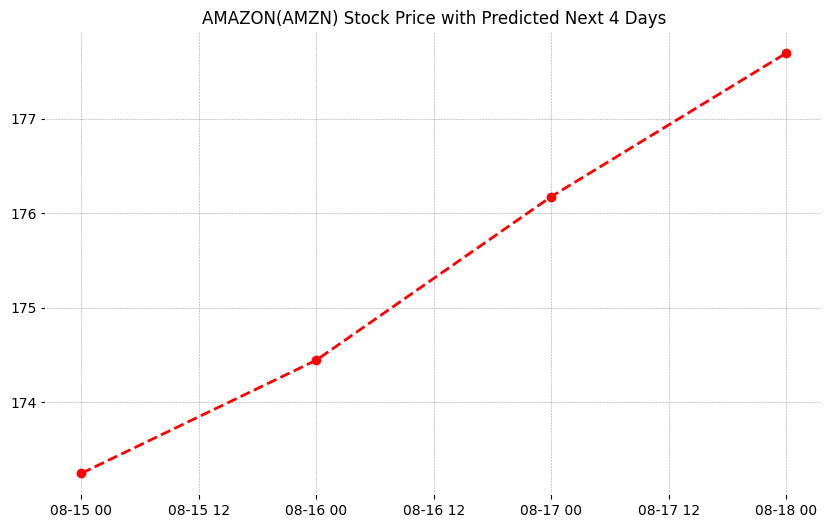

In [23]:
# Assuming 'data' is your DataFrame with the fetched AMZN stock data
# Make sure it contains Open, High, Low, Close, and Volume columns

# Creating a list of dates for the predictions
last_date = data.index[-1]
next_day = last_date + pd.Timedelta(days=1)
prediction_dates = pd.date_range(start=next_day, periods=4)

# Assuming 'predicted_prices' is your list of predicted prices for the next 4 days
predictions_df = pd.DataFrame(index=prediction_dates, data=predicted_prices, columns=['Close'])

# Plotting the actual data with mplfinance
mpf.plot(data, type='candle', style='charles', volume=True)

# Overlaying the predicted data
plt.figure(figsize=(10,6))
plt.plot(predictions_df.index, predictions_df['Close'], linestyle='dashed', marker='o', color='red')

plt.title("AMAZON(AMZN) Stock Price with Predicted Next 4 Days")
plt.show()

#### Final Visual for Predictions

[*********************100%%**********************]  1 of 1 completed

1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 32ms/step


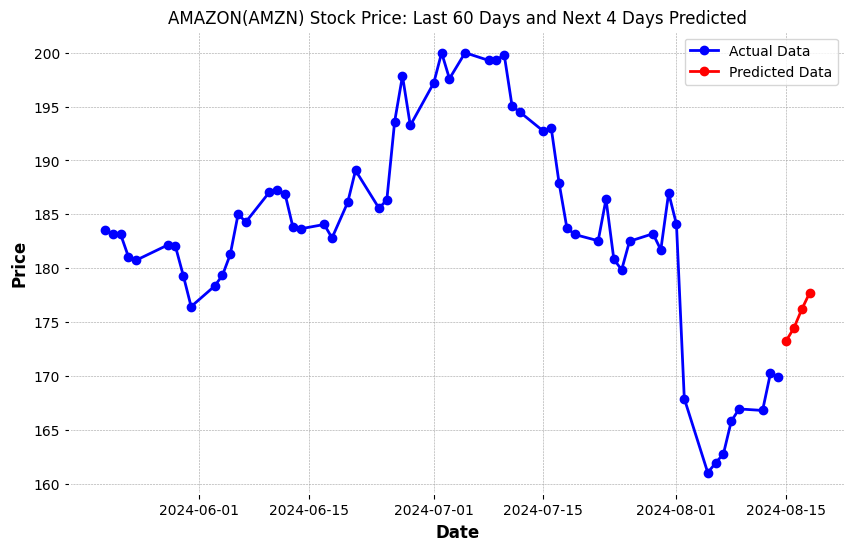

In [24]:
# Fetch the latest 60 days of AMZN stock data
data = yf.download('AMZN', period='3mo', interval='1d') # Fetch 64 days to display last 60 days in the chart

# Select 'Close' price and scale it
closing_prices = data['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(closing_prices)

# Predict the next 4 days iteratively
predicted_prices = []
current_batch = scaled_data[-60:].reshape(1, 60, 1)  # Most recent 60 days

for i in range(4):  # Predicting 4 days
    next_prediction = model.predict(current_batch)
    next_prediction_reshaped = next_prediction.reshape(1, 1, 1)
    current_batch = np.append(current_batch[:, 1:, :], next_prediction_reshaped, axis=1)
    predicted_prices.append(scaler.inverse_transform(next_prediction)[0, 0])

# Creating a list of dates for the predictions
last_date = data.index[-1]
next_day = last_date + pd.Timedelta(days=1)
prediction_dates = pd.date_range(start=next_day, periods=4)

# Adding predictions to the DataFrame
predicted_data = pd.DataFrame(index=prediction_dates, data=predicted_prices, columns=['Close'])

# Combining both actual and predicted data
combined_data = pd.concat([data['Close'], predicted_data['Close']])
combined_data = combined_data[-64:] # Last 60 days of actual data + 4 days of predictions

# Plotting the actual data
plt.figure(figsize=(10,6))
plt.plot(data.index[-60:], data['Close'][-60:], linestyle='-', marker='o', color='blue', label='Actual Data')

# Plotting the predicted data
plt.plot(prediction_dates, predicted_prices, linestyle='-', marker='o', color='red', label='Predicted Data')

plt.title("AMAZON(AMZN) Stock Price: Last 60 Days and Next 4 Days Predicted")
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()